## This notebook file is a end-to-end demonstration of how we can load the shadow model's traces and then train a machine learning based classifier which further will be used to distinguish between the member and non-member samples from target model's traces.

# Section 1: Loading Dataset

In [ ]:
# Load required libraries for data handling and numerical computation
import numpy as np
import pandas as pd

In [ ]:
# Load ViT-base training and test traces (10 classes × 10 samples each)
# Each entry corresponds to GPU execution metrics collected per sample
vit_base_data=[] #List to hold training data traces collected from shadow model
vit_base_data_test=[] #List to hold test data traces collected from target model

# Load Shadow model's traces for training the attack model
for i in range(1,101):
    temp1=[]
    for j in range(10):
        path='path to the directory/mem_csv_vit_base_gtsrb/report'+str(j)+'_'+str(i)+'.csv'
        data=pd.read_csv(path)
        temp1.append(data)
    vit_base_data.append(temp1)

# Load Target model's traces for membership inference attack
for i in range(1,31):
    temp1=[]
    for j in range(10):
        path='path to the directory/mem_csv_vit_base_gtsrb_test/report'+str(j)+'_'+str(i)+'.csv'
        data=pd.read_csv(path)
        temp1.append(data)
    vit_base_data_test.append(temp1)

# Print column names to verify correct data loading
print(vit_base_data[0][1].columns)
print(vit_base_data_test[0][1].columns)


Index(['ID', 'Process ID', 'Process Name', 'Host Name', 'Kernel Name',
       'Context', 'Stream', 'Block Size', 'Grid Size', 'Device',
       ...
       'smsp__warps_active.min.peak_sustained',
       'smsp__warps_active.min.per_cycle_active',
       'smsp__warps_active.sum.peak_sustained',
       'smsp__warps_active.sum.per_cycle_active',
       'smsp__warps_eligible.avg.per_cycle_active',
       'smsp__warps_eligible.max.per_cycle_active',
       'smsp__warps_eligible.min.per_cycle_active',
       'smsp__warps_eligible.sum.per_cycle_active', 'thread_inst_executed',
       'thread_inst_executed_true'],
      dtype='object', length=1619)
Index(['ID', 'Process ID', 'Process Name', 'Host Name', 'Kernel Name',
       'Context', 'Stream', 'Block Size', 'Grid Size', 'Device',
       ...
       'smsp__warps_active.min.peak_sustained',
       'smsp__warps_active.min.per_cycle_active',
       'smsp__warps_active.sum.peak_sustained',
       'smsp__warps_active.sum.per_cycle_active',
       'sm

# Section 2: Pre-processing Dataset

In [ ]:
# Clean the loaded dataframes by removing unnecessary columns such as ID
# This ensures only GPU metric features remain
for i in range(100):
    for j in range(10):
        vit_base_data[i][j]=vit_base_data[i][j].drop(['ID'], axis=1)
        if 0 in vit_base_data[i][j].index:
            vit_base_data[i][j] = vit_base_data[i][j].drop(index=0)

for i in range(30):
    for j in range(10):
        vit_base_data_test[i][j]=vit_base_data_test[i][j].drop(['ID'], axis=1)
        if 0 in vit_base_data_test[i][j].index:
            vit_base_data_test[i][j] = vit_base_data_test[i][j].drop(index=0)


# Section 3: Metric-based Data filtering and pre-processing

In [ ]:
# Import additional libraries for visualization and random sampling
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import random


kernel_name=['fmha_cutlassF_f32_aligned_64x64_rf_sm80'] #Fused Multi-Head Attention kernel

ltx_cols=[col for col in vit_base_data[0][1].columns if 
    col.startswith('smsp__branch_targets_threads_divergent') 
        or col.startswith('smsp__inst_executed_op_branch') 
        or col.startswith('smsp__inst_executed_op_shared_atom') 
        or col.startswith('smsp__sass_inst_executed_op_shared_') 
]
for col in ltx_cols:
    for i in range(100):
        for j in range(10):
            if vit_base_data[i][j][col].dtype == 'object':  # likely string
                vit_base_data[i][j][col] = pd.to_numeric(vit_base_data[i][j][col].astype(str).str.replace(',', '').str.strip(), errors='coerce')

    for i in range(30):
        for j in range(10):
            if vit_base_data_test[i][j][col].dtype == 'object':  # likely string
                vit_base_data_test[i][j][col] = pd.to_numeric(vit_base_data_test[i][j][col].astype(str).str.replace(',', '').str.strip(), errors='coerce')
                

print(ltx_cols)


['smsp__branch_targets_threads_divergent', 'smsp__inst_executed_op_branch.avg', 'smsp__inst_executed_op_branch.max', 'smsp__inst_executed_op_branch.min', 'smsp__inst_executed_op_branch.sum', 'smsp__inst_executed_op_shared_atom.sum', 'smsp__inst_executed_op_shared_atom.sum.pct_of_peak_sustained_elapsed', 'smsp__sass_inst_executed_op_shared_ld.sum', 'smsp__sass_inst_executed_op_shared_st.sum']


In [ ]:
# Display the shape of a sample dataframe to verify the number of features
vit_base_data[0][0].shape

(12, 1618)

# Section 4: Generating classifier model's training data and validation data by considering only the filtered Metrics. 

In [ ]:
# Combine all samples from all classes into a single dataset
# Flatten data structure for easier preprocessing and model training
col = [col for col in vit_base_data[0][1].columns if 
    col.startswith('smsp__branch_targets_threads_divergent') # 63 0:7
        or col.startswith('smsp__inst_executed_op_branch') #58 0:11
        or col.startswith('smsp__inst_executed_op_shared_atom') #63.33 0:12
        or col.startswith('smsp__sass_inst_executed_op_shared_') #70 0:4 62 0:2
]

for i in range(10):
    for j in range(10):
        for c in col:
            vit_base_data[i][j][c]=pd.to_numeric(vit_base_data[i][j][c].astype(str).str.replace(',', '').str.strip(), errors='coerce').astype('float32')
for i in range(30):
    for j in range(10):
        for c in col:
            vit_base_data_test[i][j][c]=pd.to_numeric(vit_base_data_test[i][j][c].astype(str).str.replace(',', '').str.strip(), errors='coerce').astype('float32')
           

# Loop through each DataFrame and keep only the selected columns (if they exist)
vit_base_data_df=[[[] for i in range(10)] for j in range(100)]
vit_base_data_test_df=[[[] for i in range(10)] for j in range(30)]

for i in range(len(vit_base_data)):
    for j in range(len(vit_base_data[i])):
        df2 = vit_base_data[i][j]
        # Keep only the columns that exist in the current DataFrame
        selected_cols = [c for c in col if c in df2.columns]
        vit_base_data_df[i][j] = vit_base_data[i][j][selected_cols].copy()

for i in range(len(vit_base_data_test)):
    for j in range(len(vit_base_data_test[i])):
        df2 = vit_base_data_test[i][j]
        # Keep only the columns that exist in the current DataFrame
        selected_cols = [c for c in col if c in df2.columns]
        vit_base_data_test_df[i][j] = df2[selected_cols].copy()

In [ ]:
# Print the names of the selected columns to verify
print(col)

['smsp__branch_targets_threads_divergent', 'smsp__inst_executed_op_branch.avg', 'smsp__inst_executed_op_branch.max', 'smsp__inst_executed_op_branch.min', 'smsp__inst_executed_op_branch.sum', 'smsp__inst_executed_op_shared_atom.sum', 'smsp__inst_executed_op_shared_atom.sum.pct_of_peak_sustained_elapsed', 'smsp__sass_inst_executed_op_shared_ld.sum', 'smsp__sass_inst_executed_op_shared_st.sum']


In [ ]:
# Print the shape of a sample dataframe to verify the number of features
vit_base_data_test_df[0][0].shape

(12, 9)

# Dataset re-arrangement and providing label for training and test samples for both shadow and target model. Also, selecting appropiate rnage of FMHA kernel instances for achieving maximum attack success rate.

In [ ]:
# Generate labels for membership inference:
#  - Train samples = member (1)
#  - Test samples = non-member (0)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train=[]
y_train=[]
X_test=[]
y_test=[]

for i in range(100):
    for j in range(10):
        r = vit_base_data_df[i][j]  # shape: (12, 2)
        j_col = np.full((r.shape[0], 1), j)  # shape: (12, 1), filled with iamge class label
        r_with_class = np.concatenate([r, j_col], axis=1)  # shape: (12, 3)
        X_train.append(r_with_class)

        if i < 50: #For each class, first 50 sample traces are collected from shadow model's training set
            y_train.append(1)
        else:
            y_train.append(0)

for i in range(30):
    for j in range(10):
        r = vit_base_data_test_df[i][j]  # shape: (12, 2)
        j_col = np.full((r.shape[0], 1), j) # shape: (12, 1), filled with iamge class label
        r_with_class = np.concatenate([r, j_col], axis=1)
        X_test.append(r_with_class)

        if i < 15: #For each class, first 15 test sample traces are collected from target model's training set
            y_test.append(1)
        else:
            y_test.append(0)


X_train = np.array(X_train) #Shadow model's samples traces for classfier training
y_train = np.array(y_train) #Shadow model's samples traces labels
X_test = np.array(X_test) #Target model's samples traces for  membership inferenece attack
y_test = np.array(y_test) #Target model's samples traces labels


X_train = X_train[:,0:8, :] #Selecting only the first 8 FMHA kernel instances for training the attack model
X_test = X_test[:, 0:8, :] #Selecting only the first 8 FMHA kernel instances for MIA testing on Target model

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1000, 8, 10) (1000,)
(300, 8, 10) (300,)


In [10]:
# Ensure all elements are float32
X_train = X_train.astype(np.float32)

In [ ]:
# Print unique labels and counts to confirm correct dataset creation
import numpy as np
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([500, 500]))
(array([0, 1]), array([150, 150]))


# Model training

In [ ]:
# Build the attack model (BiLSTM-based neural network)
# This model attempts to classify GPU traces as member or non-member
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, BatchNormalization
import numpy as np
# np.random.seed(42) 
from sklearn.model_selection import train_test_split

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disables GPU
# os.environ['PYTHONHASHSEED']=str(42)
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(42)
   tf.random.set_seed(42)
   np.random.seed(42)
   random.seed(42)

#make some random data
reset_random_seeds()

# Now import TensorFlow
import tensorflow as tf

# Your input data shape: (samples, sequence_length, feature_dim)
num_samples = X_train.shape[0]
sequence_length = X_train.shape[1]
feature_dim = X_train.shape[2]


# Define the model
# Stacked BiLSTM Layers
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(sequence_length, feature_dim)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32, return_sequences=False)))
model.add(Dropout(0.2))


# Fully connected hidden layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer for 2-class classification
model.add(Dense(1, activation='sigmoid'))


# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Separate features and class column
features_train = X_train[:, :, :-1]  # all but last column
class_train = X_train[:, :, -1:]     # last column, keep dims for concatenation

# Compute mean and std from features only
mean = features_train.mean(axis=(0, 1), keepdims=True)
std = features_train.std(axis=(0, 1), keepdims=True)

# Normalize features
features_train = (features_train - mean) / (std + 1e-8)

# Reattach the class column
X_train = np.concatenate([features_train, class_train], axis=-1)

# Summary
model.summary()
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
# Train
history = model.fit(
    X_train_split, y_train_split,
    epochs=200,
    batch_size=45,
    validation_data=(X_val_split, y_val_split)
)

2025-11-20 20:31:53.389641: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-11-20 20:31:53.389656: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="-1"
2025-11-20 20:31:53.389660: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-11-20 20:31:53.389662: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-11-20 20:31:53.389664: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: rtx3060-MS-7D90
2025-11-20 20:31:53.389665: I external/local_xla/xla/stream_executor/cu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 8, 128)         │        38,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,841 (327.50 KB)

 Trainable params: 83,841 (327.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5312 - loss: 0.6977 - val_accuracy: 0.5000 - val_loss: 0.7010
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5115 - loss: 0.6978 - val_accuracy: 0.4800 - val_loss: 0.6948
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5239 - loss: 0.6921 - val_accuracy: 0.5150 - val_loss: 0.6938
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5711 - loss: 0.6875 - val_accuracy: 0.4750 - val_loss: 0.6974
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5831 - loss: 0.6796 - val_accuracy: 0.5100 - val_loss: 0.6978
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5520 - loss: 0.6865 - val_accuracy: 0.5300 - val_loss: 0.6873
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5809 - loss: 0.6756 - val_accuracy: 0.5600 - val_loss: 0.6839
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6087 - loss: 0.6646 - val_accuracy: 0.5450 - 

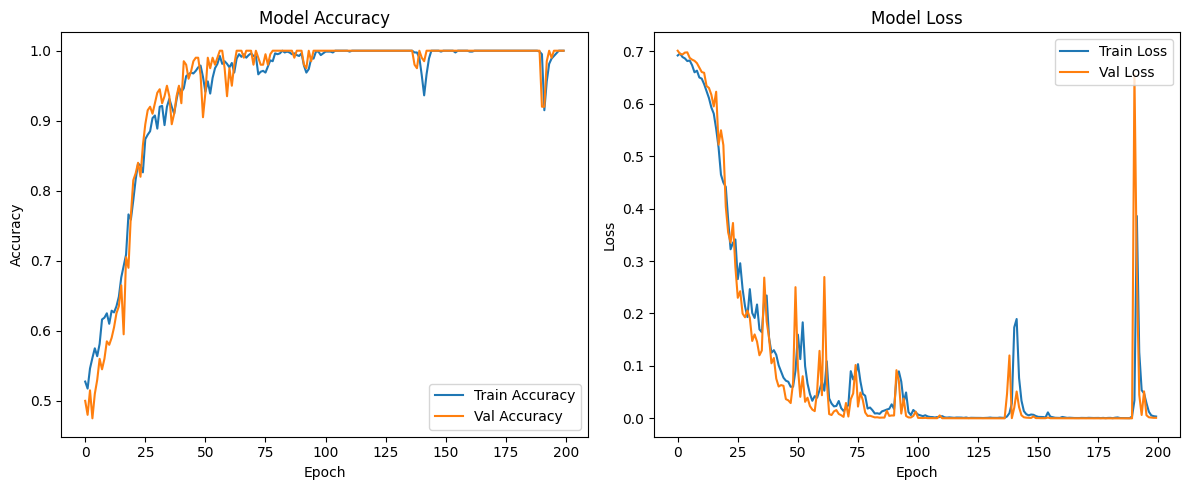

In [ ]:
# Plot training and validation accuracy/loss curves
# Used to check for overfitting or underfitting in the attack model
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


# Membership Inference Attack on Target Model Data

Target model Attack Success Rate (ASR)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test Accuracy: 1.0000
Confusion Matrix:
 [[150   0]
 [  0 150]]


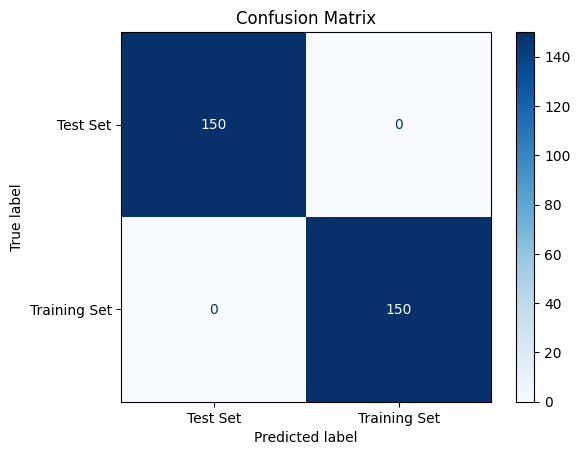

In [ ]:
# Generate predictions and calculate accuracy + confusion matrix
# This measures how successful the membership inference attack is on target model's data

# Predict
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Separate features and class column
features_train = X_test[:, :, :-1]  # all but last column
class_train = X_test[:, :, -1:]     # last column, keep dims for concatenation

# Compute mean and std from features only
mean = features_train.mean(axis=(0, 1), keepdims=True)
std = features_train.std(axis=(0, 1), keepdims=True)

# Normalize features
features_train = (features_train - mean) / (std + 1e-8)

# Reattach the class column
X_test = np.concatenate([features_train, class_train], axis=-1)

# Predict probabilities
predictions = model.predict(X_test)

# # Convert probabilities to binary labels
predicted_labels = (predictions > 0.5).astype(int)

# Accuracy
acc = accuracy_score(y_test, predicted_labels)
print(f"Test Accuracy: {acc:.4f}")


# Confusion matrix
cm = confusion_matrix(y_test, predicted_labels)
print("Confusion Matrix:\n", cm)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Test Set", "Training Set"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



Target Model Attack AUC & F1 Score

AUC Score: 1.0000
F1 Score: 1.0000


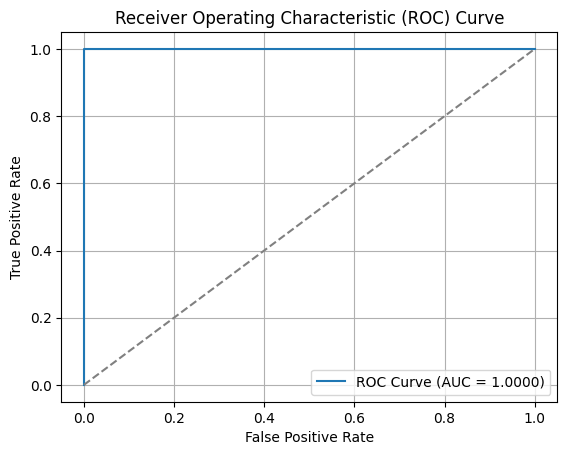

In [16]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    f1_score
)
import matplotlib.pyplot as plt
import numpy as np

# --- Assuming `predictions` is a probability array (floats between 0 and 1)
# and `y_test` is your true label array (0s and 1s) ---

# Binary predictions using threshold 0.5
predicted_labels = (predictions >= 0.5).astype(int)

# AUC Score
auc_score = roc_auc_score(y_test, predictions)
print(f"AUC Score: {auc_score:.4f}")

# F1 Score
f1 = f1_score(y_test, predicted_labels)
print(f"F1 Score: {f1:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
